Notebook where we compare our pipelines

In [1]:
from glob import glob
from os.path import join as opj

Compute group- and subject-level similarities between tasks for all the different pipelines

In [22]:
from scipy.stats import ttest_1samp, spearmanr

subject_sims = {}
group_sims = {}

pipeline_dict = {}
for experiment in tqdm.tqdm(glob("../results/experiments/*/shen/*.yaml")):
    
    folder = Path(experiment).parent.parent.as_posix()
    case_name = experiment.split("/")[-1].split(".yaml")[0]
    
    if case_name=="pipeline_main":
        case_name = "pipeline1 (main)"
        
    if case_name=="pipeline_edge_w_tasks":
        case_name = "pipeline10"
    
    pipeline_dict[case_name] = folder.split("/")[-1]
    
    stroop_node = glob(opj(folder, "shen", "task-stroop", "node", "*", "Incongruent-Congruent", "effect_size.nii.gz"))
    stroop_node = np.array([np.squeeze(load_img(img).get_fdata()) for img in stroop_node])
    t_stroop_node, _ = np.apply_along_axis(ttest_1samp, 0, stroop_node, popmean=0)

    msit_node = glob(opj(folder, "shen", "task-msit", "node", "*", "Incongruent-Congruent", "effect_size.nii.gz"))
    msit_node = np.array([np.squeeze(load_img(img).get_fdata()) for img in msit_node])
    t_msit_node, _ = np.apply_along_axis(ttest_1samp, 0, msit_node, popmean=0)
        
    stroop_edge = glob(opj(folder, "shen", "task-stroop","edge", "*", "Incongruent-Congruent", "effect_size.nii.gz"))
    stroop_edge = np.array([squareform(np.squeeze(load_img(img).get_fdata()), checks=False) 
                            for img in stroop_edge])
    t_stroop_edge, _ = np.apply_along_axis(ttest_1samp, 0, stroop_edge, popmean=0)
    
    msit_edge = glob(opj(folder, "shen", "task-msit", "edge", "*", "Incongruent-Congruent", "effect_size.nii.gz"))
    msit_edge = np.array([squareform(np.squeeze(load_img(img).get_fdata()), checks=False) 
                            for img in msit_edge])
    t_msit_edge, _ = np.apply_along_axis(ttest_1samp, 0, msit_edge, popmean=0)
    
    group_sims[case_name] = pd.DataFrame({
        "activation": [spearmanr(t_stroop_node, t_msit_node)[0]],
        "connectivity": [spearmanr(t_stroop_edge, t_msit_edge)[0]]})

    subject_sims[case_name] = pd.DataFrame({
        "activation": [spearmanr(a,b)[0] for a,b in zip(stroop_node, msit_node)],
        "connectivity": [spearmanr(a,b)[0] for a,b in zip(stroop_edge, msit_edge)]
    })
    

# Rearrange as data frames
group_sims_df = []
for ii, (key, value) in enumerate(group_sims.items()):
    df = value.copy()
    df['pipeline'] = key
    group_sims_df.append(df)
    
group_sims_df = pd.concat(group_sims_df, axis=0)

subject_sims_df = []
for ii, (key, value) in enumerate(subject_sims.items()):
    df = value.copy()
    df['pipeline'] = key
    subject_sims_df.append(df)
    
subject_sims_df = pd.concat(subject_sims_df, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.83s/it]


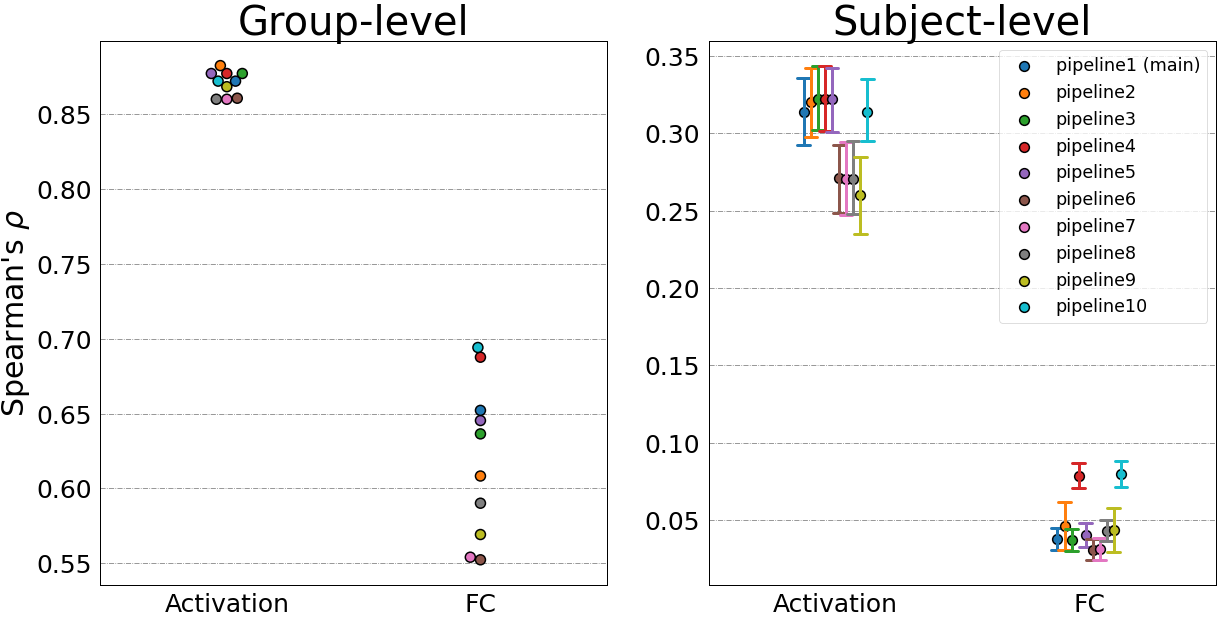

In [18]:
hue_order = ['pipeline1 (main)', 'pipeline2', 'pipeline3', 'pipeline4',
             'pipeline5', 'pipeline6', 'pipeline7',
             'pipeline8', 'pipeline9', 'pipeline10']

sns.set_context("paper", font_scale = 2)
#"whitegrid", 
with sns.axes_style("whitegrid", 
                    rc={"axes.edgecolor": 'k', 
                        "grid.color": 'grey', "grid.linestyle":'-.',
                       'text.color': '.0', 
                        'axes.labelcolor': 'k',
                       'xtick.color': 'k',
                        'ytick.color': 'k', 
                       'font.family': ['sans-serif'],
                        'font.sans-serif': ['Arial']}):
    
    fig, axs = plt.subplots(ncols=2, figsize=(20,10))
    sns.swarmplot(x="variable", 
                  y="value", hue="pipeline", hue_order = hue_order, 
                  data=pd.melt(group_sims_df, id_vars="pipeline"), 
                  ax=axs[0], size=10)
    
    sns.pointplot(x="variable", y="value", hue="pipeline", hue_order=hue_order,
                  dodge=True, 
                  capsize=0.05, join=False, scale=1.8, errwidth=3,
                  data=pd.melt(subject_sims_df, id_vars="pipeline"), ax=axs[1])
    
    axs[0].tick_params(labelsize=25)
    axs[1].tick_params(labelsize=25)
    
    axs[0].set_xlabel("")
    axs[1].set_xlabel("")
    
    axs[0].set_ylabel(r"Spearman's $\rho$", size=30)
    axs[1].set_ylabel("")
    axs[0].legend(fontsize=15)
    axs[1].legend(fontsize=15)
    axs[0].set_title("Group-level", size=40)
    axs[1].set_title("Subject-level", size=40)
    axs[0].set_xticklabels(["Activation", "FC"])
    axs[1].set_xticklabels(["Activation", "FC"])

    for patch1, patch2 in zip(axs[0].collections, axs[1].collections):
        patch1.set_edgecolor('k')
        patch1.set_linewidth(1.5)
        patch2.set_edgecolor('k')
        patch2.set_linewidth(1.5)        
    
    axs[1].legend()
    
    axs[0].legend().remove()

    plt.savefig("../figures/Fig_supp_pipelines.svg", dpi=300)
    plt.savefig("../figures/Fig_supp_pipelines.png", dpi=300)
    plt.savefig("../figures/Fig_supp_pipelines.pdf", dpi=300)

In [15]:
print(max(group_sims_df.connectivity))
print(min(group_sims_df.connectivity))

0.6941583534179072
0.5523668327186169


In [16]:
print(max(group_sims_df.activation))
print(min(group_sims_df.activation))

0.882435489733156
0.8599679435827003


In [33]:
pipeline_dict['pipeline10']

'pipeline_events-0_denoise-fir_whiten-ar1_hrf-1_zscore-0_gsr-1'